# Unsupervised Learning Trading Strategy

Outlined below is a general overview of the steps followed in this project.

* Download/Load SP500 stocks prices data.
* Calculate different features and indicators on each stock.
* Aggregate on monthly level and filter top 150 most liquid stocks.
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to SP500 returns.

# All Packages Needed:
* pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

In [ ]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import sklearn
import warnings
warnings.filterwarnings('ignore')

## 1. Downloading/Loading SP500 stocks prices data.

In [2]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2024-03-12'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%***********************]  503 of 503 completed

4 Failed downloads:
['AMTM', 'SOLV', 'SW', 'GEV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2016-03-14 00:00:00 -> 2024-03-12) (Yahoo error = "Data doesn\'t exist for startDate = 1457928000, endDate = 1710216000")')


Price                              adj close       close        high  \
date                      ticker                                       
2016-03-14 00:00:00+00:00 A        36.384457   39.020000   39.169998   
                          AAPL     23.371300   25.629999   25.727501   
                          ABBV     39.477165   57.209999   57.730000   
                          ABT      34.398003   40.500000   40.680000   
                          ACGL     23.313334   23.313334   23.473333   
...                                      ...         ...         ...   
2024-03-11 00:00:00+00:00 XYL     125.517143  126.180000  127.040001   
                          YUM     138.702911  140.080002  140.410004   
                          ZBH     127.233459  128.039993  128.360001   
                          ZBRA    280.230011  280.230011  283.540009   
                          ZTS     182.534134  183.490005  183.990005   

Price                                    low        open       volume  
date                      ticker                                       
2016-03-14 00:00:00+00:00 A        38.410000   38.980000     929600.0  
                          AAPL     25.445000   25.477501  100304400.0  
                          ABBV     56.970001   57.669998    4650800.0  
                          ABT      39.990002   40.310001    5707800.0  
                          ACGL     22.986668   23.190001     783000.0  
...                                      ...         ...          ...  
2024-03-11 00:00:00+00:00 XYL     125.510002  126.879997    1019900.0  
                          YUM     138.740005  139.460007    1711300.0  
                          ZBH     126.169998  126.699997    1079800.0  
                          ZBRA    279.190002  282.299988     268800.0  
                          ZTS     180.419998  182.619995    3383500.0  

[985205 rows x 6 columns]

## 2. Calculating features and technical indicators for each stock.

* Garman-Klass Volatility


\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

In [3]:
# Garman-Klass Volatility
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

#RSI
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

# Bollinger Bands
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

#ATR
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

#MACD
df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

#Dollar Volume
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price                              adj close       close        high  \
date                      ticker                                       
2016-03-14 00:00:00+00:00 A        36.384457   39.020000   39.169998   
                          AAPL     23.371300   25.629999   25.727501   
                          ABBV     39.477165   57.209999   57.730000   
                          ABT      34.398003   40.500000   40.680000   
                          ACGL     23.313334   23.313334   23.473333   
...                                      ...         ...         ...   
2024-03-11 00:00:00+00:00 XYL     125.517143  126.180000  127.040001   
                          YUM     138.702911  140.080002  140.410004   
                          ZBH     127.233459  128.039993  128.360001   
                          ZBRA    280.230011  280.230011  283.540009   
                          ZTS     182.534134  183.490005  183.990005   

Price                                    low        open       volume  \
date                      ticker                                        
2016-03-14 00:00:00+00:00 A        38.410000   38.980000     929600.0   
                          AAPL     25.445000   25.477501  100304400.0   
                          ABBV     56.970001   57.669998    4650800.0   
                          ABT      39.990002   40.310001    5707800.0   
                          ACGL     22.986668   23.190001     783000.0   
...                                      ...         ...          ...   
2024-03-11 00:00:00+00:00 XYL     125.510002  126.879997    1019900.0   
                          YUM     138.740005  139.460007    1711300.0   
                          ZBH     126.169998  126.699997    1079800.0   
                          ZBRA    279.190002  282.299988     268800.0   
                          ZTS     180.419998  182.619995    3383500.0   

Price                             garman_klass_vol        rsi    bb_low  \
date                      ticker                                          
2016-03-14 00:00:00+00:00 A              -0.001642        NaN       NaN   
                          AAPL           -0.002815        NaN       NaN   
                          ABBV           -0.055404        NaN       NaN   
                          ABT            -0.009571        NaN       NaN   
                          ACGL            0.000209        NaN       NaN   
...                                            ...        ...       ...   
2024-03-11 00:00:00+00:00 XYL             0.000028  64.430703  4.806359   
                          YUM             0.000060  66.405355  4.872833   
                          ZBH             0.000141  57.907413  4.806143   
                          ZBRA            0.000099  56.265585  5.538903   
                          ZTS             0.000192  42.974681  5.181394   

Price                               bb_mid   bb_high       atr      macd  \
date                      ticker                                           
2016-03-14 00:00:00+00:00 A            NaN       NaN       NaN       NaN   
                          AAPL         NaN       NaN       NaN       NaN   
                          ABBV         NaN       NaN       NaN       NaN   
                          ABT          NaN       NaN       NaN       NaN   
                          ACGL         NaN       NaN       NaN       NaN   
...                                    ...       ...       ...       ...   
2024-03-11 00:00:00+00:00 XYL     4.833566  4.860772 -0.048368  1.374559   
                          YUM     4.915193  4.957553  0.093711  1.569719   
                          ZBH     4.835845  4.865548 -0.357955  0.295424   
                          ZBRA    5.624706  5.710510  0.189816  0.909816   
                          ZTS     5.246548  5.311703  0.965146 -1.172312   

Price                             dollar_volume  
date                      ticker                 
2016-03-14 00:00:00+00:00 A           33.822991 

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, the business-daily data needs to be converted to month-end frequency.

In [4]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol  \
date                      ticker                                                
2016-04-30 00:00:00+00:00 A           62.914972   38.266556         -0.001552   
                          AAPL      3960.890963   21.369743         -0.003202   
                          ABBV       278.434530   42.496876         -0.050477   
                          ABT        305.256964   33.240910         -0.013545   
                          ACGL        25.113596   23.496668          0.000146   
...                                         ...         ...               ...   
2024-03-31 00:00:00+00:00 ABNB       709.179317  162.990005          0.000090   
                          CEG        557.275057  167.342010          0.000246   
                          GEHC       246.774216   92.902107          0.000178   
                          KVUE       315.741780   19.747244          0.000030   
                          VLTO       101.301581   88.517105          0.000211   

                                        rsi    bb_low    bb_mid   bb_high  \
date                      ticker                                            
2016-04-30 00:00:00+00:00 A       55.694162  3.624379  3.665685  3.706990   
                          AAPL    24.149398  3.132645  3.229502  3.326359   
                          ABBV    64.545685  3.715166  3.752966  3.790767   
                          ABT     30.351579  3.565411  3.626884  3.688356   
                          ACGL    49.762983  3.181313  3.200368  3.219422   
...                                     ...       ...       ...       ...   
2024-03-31 00:00:00+00:00 ABNB    61.429401  4.985524  5.053439  5.121354   
                          CEG     69.552167  4.738302  5.011949  5.285597   
                          GEHC    68.916032  4.414504  4.501007  4.587510   
                          KVUE    55.658446  2.953430  2.988569  3.023708   
                          VLTO    65.214426  4.428071  4.470798  4.513524   

                                       atr      macd  
date                      ticker                      
2016-04-30 00:00:00+00:00 A      -1.293749  0.107142  
                          AAPL   -1.036722 -0.547744  
                          ABBV   -0.975180  0.311850  
                          ABT    -0.895612 -0.001984  
                          ACGL   -0.791180 -0.204769  
...                                    ...       ...  
2024-03-31 00:00:00+00:00 ABNB   -0.642557  0.998807  
                          CEG     5.468711  5.241046  
                          GEHC    0.699681  1.810352  
                          KVUE   -1.129649  0.505806  
                          VLTO   -0.815308  1.205176  

[47006 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [5]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi  \
date                      ticker                                            
2017-03-31 00:00:00+00:00 AAPL     33.442245         -0.001950  72.899807   
                          ABBV     46.682083         -0.044136  58.182075   
                          ABT      38.674023         -0.007136  52.441438   
                          ACN     105.915352         -0.006539  45.957838   
                          ADBE    130.130005          0.000042  78.905898   
...                                      ...               ...        ...   
2024-03-31 00:00:00+00:00 MRNA    111.980003          0.003197  63.695544   
                          UBER     77.470001          0.000365  59.408202   
                          CRWD    317.369995          0.000263  54.380051   
                          PLTR     25.350000          0.001575  61.152015   
                          ABNB    162.990005          0.000090  61.429401   

                                    bb_low    bb_mid   bb_high       atr  \
date                      ticker                                           
2017-03-31 00:00:00+00:00 AAPL    3.495687  3.519583  3.543479 -1.186764   
                          ABBV    3.844389  3.867959  3.891529 -1.639546   
                          ABT     3.677816  3.693295  3.708775 -1.381697   
                          ACN     4.662517  4.696699  4.730881 -1.002379   
                          ADBE    4.775331  4.833421  4.891511 -1.314983   
...                                    ...       ...       ...       ...   
2024-03-31 00:00:00+00:00 MRNA    4.426260  4.556692  4.687124 -0.390442   
                          UBER    4.281794  4.366242  4.450690  1.610253   
                          CRWD    5.703387  5.769367  5.835346  2.876314   
                          PLTR    3.159924  3.240184  3.320445  0.460741   
                          ABNB    4.985524  5.053439  5.121354 -0.642557   

                                      macd  
date                      ticker            
2017-03-31 00:00:00+00:00 AAPL    0.001387  
                          ABBV    0.048043  
                          ABT    -0.148129  
                          ACN    -0.315236  
                          ADBE    0.157730  
...                                    ...  
2024-03-31 00:00:00+00:00 MRNA    0.176161  
                          UBER    1.754157  
                          CRWD    0.620105  
                          PLTR    1.359308  
                          ABNB    0.998807  

[12665 rows x 8 columns]

## 4. Calculating Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags are computed.

In [6]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi  \
date                      ticker                                            
2018-03-31 00:00:00+00:00 AAPL     39.674957         -0.000793  44.825113   
                          ABBV     70.080757         -0.034340  33.321306   
                          ABT      53.302376         -0.004611  47.669997   
                          ACN     138.353195         -0.001148  46.272168   
                          ADBE    216.080002          0.000878  53.315887   
...                                      ...               ...        ...   
2024-03-31 00:00:00+00:00 MRNA    111.980003          0.003197  63.695544   
                          UBER     77.470001          0.000365  59.408202   
                          CRWD    317.369995          0.000263  54.380051   
                          PLTR     25.350000          0.001575  61.152015   
                          ABNB    162.990005          0.000090  61.429401   

                                    bb_low    bb_mid   bb_high       atr  \
date                      ticker                                           
2018-03-31 00:00:00+00:00 AAPL    3.689212  3.743409  3.797605 -0.746142   
                          ABBV    4.223787  4.404049  4.584311  2.389300   
                          ABT     3.975609  4.020808  4.066008 -0.562250   
                          ACN     4.894494  4.961246  5.027997 -0.169813   
                          ADBE    5.341287  5.392512  5.443737 -0.306413   
...                                    ...       ...       ...       ...   
2024-03-31 00:00:00+00:00 MRNA    4.426260  4.556692  4.687124 -0.390442   
                          UBER    4.281794  4.366242  4.450690  1.610253   
                          CRWD    5.703387  5.769367  5.835346  2.876314   
                          PLTR    3.159924  3.240184  3.320445  0.460741   
                          ABNB    4.985524  5.053439  5.121354 -0.642557   

                                      macd  return_1m  return_2m  return_3m  \
date                      ticker                                              
2018-03-31 00:00:00+00:00 AAPL   -0.435977  -0.058051   0.003083  -0.001511   
                          ABBV   -2.599707  -0.176724  -0.081614  -0.004783   
                          ABT    -0.259304  -0.006796  -0.018183   0.017994   
                          ACN    -0.810200  -0.046643  -0.022659   0.000892   
                          ADBE    0.194819   0.033233   0.040047   0.072327   
...                                    ...        ...        ...        ...   
2024-03-31 00:00:00+00:00 MRNA    0.176161   0.214007   0.052694   0.040348   
                          UBER    1.754157  -0.025535   0.089457   0.079580   
                          CRWD    0.620105  -0.020916   0.041646   0.075211   
                          PLTR    1.359308   0.010766   0.255194   0.138682   
                          ABNB    0.998807   0.035054   0.063379   0.061838   

                                  return_6m  return_9m  return_12m  
date                      ticker                                    
2018-03-31 00:00:00+00:00 AAPL     0.015550   0.018421    0.014344  
                          ABBV     0.012954   0.032691    0.034437  
                          ABT      0.021154   0.025241    0.027095  
                          ACN      0.023189   0.025388    0.022514  
                          ADBE     0.063696   0.048212    0.043165  
...                                     ...        ...         ...  
2024-03-31 00:00:00+00:00 MRNA     0.013554  -0.009025   -0.025982  
                          UBER     0.090800   0.067129    0.077307  
                          CRWD     0.112527   0.089385    0.072347  
                          PLTR     0.079716   0.057476    0.095873  
                          ABNB     0.029112   0.027072    0.022771  

[10484 rows x 14 columns]

## 5. Downloading Fama-French Factors and Calculating Rolling Factor Betas.

* The Fama—French data to estimate the exposure of assets to common risk factors using linear regression will be introduced.

* The five Fama—French factors: market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* The historical factor returns can be accessed using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [7]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

if isinstance(factor_data.index, pd.MultiIndex):
    date_index = factor_data.index.get_level_values(0).tz_localize(None)
    factor_data.index = pd.MultiIndex.from_arrays([date_index] + [factor_data.index.get_level_values(i) for i in range(1, factor_data.index.nlevels)])

if isinstance(data.index, pd.MultiIndex):
    date_index_data = data.index.get_level_values(0).tz_localize(None)
    data.index = pd.MultiIndex.from_arrays([date_index_data] + [data.index.get_level_values(i) for i in range(1, data.index.nlevels)])

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-03-31 AAPL   -0.0235  0.0360 -0.0020 -0.0042 -0.0002  -0.058051
           ABBV   -0.0235  0.0360 -0.0020 -0.0042 -0.0002  -0.176724
           ABT    -0.0235  0.0360 -0.0020 -0.0042 -0.0002  -0.006796
           ACN    -0.0235  0.0360 -0.0020 -0.0042 -0.0002  -0.046643
           ADBE   -0.0235  0.0360 -0.0020 -0.0042 -0.0002   0.033233
...                   ...     ...     ...     ...     ...        ...
2024-03-31 VRTX    0.0283 -0.0118  0.0421  0.0147  0.0119  -0.014902
           VZ      0.0283 -0.0118  0.0421  0.0147  0.0119   0.002749
           WFC     0.0283 -0.0118  0.0421  0.0147  0.0119   0.026983
           WMT     0.0283 -0.0118  0.0421  0.0147  0.0119   0.034977
           XOM     0.0283 -0.0118  0.0421  0.0147  0.0119   0.043054

[10484 rows x 6 columns]

* Filter out stocks with less than 10 months of data.

In [8]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-03-31 AAPL   -0.0235  0.0360 -0.0020 -0.0042 -0.0002  -0.058051
           ABBV   -0.0235  0.0360 -0.0020 -0.0042 -0.0002  -0.176724
           ABT    -0.0235  0.0360 -0.0020 -0.0042 -0.0002  -0.006796
           ACN    -0.0235  0.0360 -0.0020 -0.0042 -0.0002  -0.046643
           ADBE   -0.0235  0.0360 -0.0020 -0.0042 -0.0002   0.033233
...                   ...     ...     ...     ...     ...        ...
2024-03-31 VRTX    0.0283 -0.0118  0.0421  0.0147  0.0119  -0.014902
           VZ      0.0283 -0.0118  0.0421  0.0147  0.0119   0.002749
           WFC     0.0283 -0.0118  0.0421  0.0147  0.0119   0.026983
           WMT     0.0283 -0.0118  0.0421  0.0147  0.0119   0.034977
           XOM     0.0283 -0.0118  0.0421  0.0147  0.0119   0.043054

[10445 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [9]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-03-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-03-31 VRTX    0.266368  0.674660 -0.671447  0.415262  0.791477
           VZ      0.486751 -1.065968  0.475076  0.027567 -0.117037
           WFC     1.165175  0.336580  1.134680 -0.565797 -0.713414
           WMT     0.523056  0.218558 -0.678582  0.713512  0.594509
           XOM     0.780468  0.053337  0.475547  0.899805  0.502169

[10445 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.

In [10]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10337 entries, (Timestamp('2018-03-31 00:00:00'), 'AAPL') to (Timestamp('2024-03-31 00:00:00'), 'CRWD')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10337 non-null  float64
 1   rsi               10337 non-null  float64
 2   bb_low            10337 non-null  float64
 3   bb_mid            10337 non-null  float64
 4   bb_high           10337 non-null  float64
 5   atr               10337 non-null  float64
 6   macd              10337 non-null  float64
 7   return_1m         10337 non-null  float64
 8   return_2m         10337 non-null  float64
 9   return_3m         10337 non-null  float64
 10  return_6m         10337 non-null  float64
 11  return_9m         10337 non-null  float64
 12  return_12m        10337 non-null  float64
 13  Mkt-RF            10337 non-null  float64
 14  SMB               10337 non-null  float64
 15  HML      

## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* Predefined centroids can be initialized for each cluster based on your research.

* For visualization purposes, I will initially rely on the ‘k-means++’ initialization.

* Then centroids will be predefined for each cluster.

In [11]:
from sklearn.cluster import KMeans
import numpy as np

if 'cluster' in data.columns:
    data = data.drop('cluster', axis=1)

initial_centroids = data.sample(n=4, random_state=0).values

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-03-31 AAPL           -0.000793  44.825113  3.689212  3.743409  3.797605   
           ABBV           -0.034340  33.321306  4.223787  4.404049  4.584311   
           ABT            -0.004611  47.669997  3.975609  4.020808  4.066008   
           ACN            -0.001148  46.272168  4.894494  4.961246  5.027997   
           ADBE            0.000878  53.315887  5.341287  5.392512  5.443737   
...                             ...        ...       ...       ...       ...   
2024-03-31 WMT             0.000097  70.234097  4.030317  4.078916  4.127515   
           XOM             0.000104  65.420930  4.604760  4.643778  4.682797   
           MRNA            0.003197  63.695544  4.426260  4.556692  4.687124   
           UBER            0.000365  59.408202  4.281794  4.366242  4.450690   
           CRWD            0.000263  54.380051  5.703387  5.769367  5.835346   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-03-31 AAPL   -0.746142 -0.435977  -0.058051   0.003083  -0.001511   
           ABBV    2.389300 -2.599707  -0.176724  -0.081614  -0.004783   
           ABT    -0.562250 -0.259304  -0.006796  -0.018183   0.017994   
           ACN    -0.169813 -0.810200  -0.046643  -0.022659   0.000892   
           ADBE   -0.306413  0.194819   0.033233   0.040047   0.072327   
...                     ...       ...        ...        ...        ...   
2024-03-31 WMT     0.601432  2.348294   0.034977   0.049400   0.049003   
           XOM     0.160320  1.287514   0.043054   0.034533   0.032453   
           MRNA   -0.390442  0.176161   0.214007   0.052694   0.040348   
           UBER    1.610253  1.754157  -0.025535   0.089457   0.079580   
           CRWD    2.876314  0.620105  -0.020916   0.041646   0.075211   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-03-31 AAPL     0.015550   0.018421    0.014344  1.323191 -0.343307   
           ABBV     0.012954   0.032691    0.034437  0.456287  0.517182   
           ABT      0.021154   0.025241    0.027095  0.809976 -0.135271   
           ACN      0.023189   0.025388    0.022514  1.220393 -0.182285   
           ADBE     0.063696   0.048212    0.043165  1.210533 -0.442542   
...                      ...        ...         ...       ...       ...   
2024-03-31 WMT      0.022392   0.017231    0.018626  0.553583  0.251160   
           XOM     -0.009494   0.004777    0.002445  0.807914 -0.010967   
           MRNA     0.013554  -0.009025   -0.025982  1.517991  1.307991   
           UBER     0.090800   0.067129    0.077307  1.300055  0.268423   
           CRWD     0.112527   0.089385    0.072347  0.577573 -1.622734   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-03-31 AAPL   -0.608559  0.466561  0.573839        2  
           ABBV   -0.148218  0.437873  0.370658        0  
           ABT    -0.486327  0.284517  0.973804        2  
           ACN    -0.281886  0.301080  0.145821        2  
           ADBE   -0.181237  0.004862 -0.571282        3  
...                     ...       ...       ...      ...  
2024-03-31 WMT    -0.969326  0.579779  0.972679        1  
           XOM     0.466071  0.831727  0.572469        1  
           MRNA   -0.945405  1.108478  1.594675        3  
           UBER   -0.234711 -2.051383 -0.785459        3  
           CRWD    0.226570 -3.087509 -1.729672        2  

[10337 rows x 19 columns]

In [12]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return


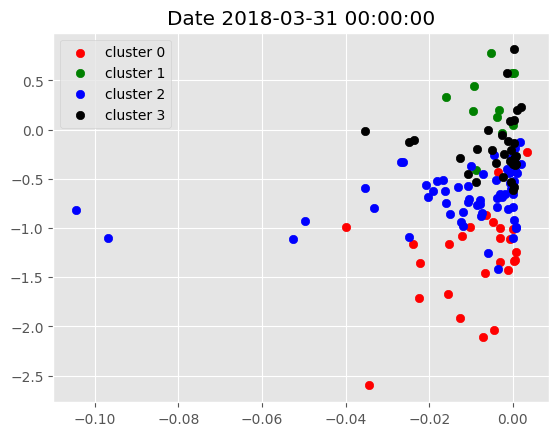

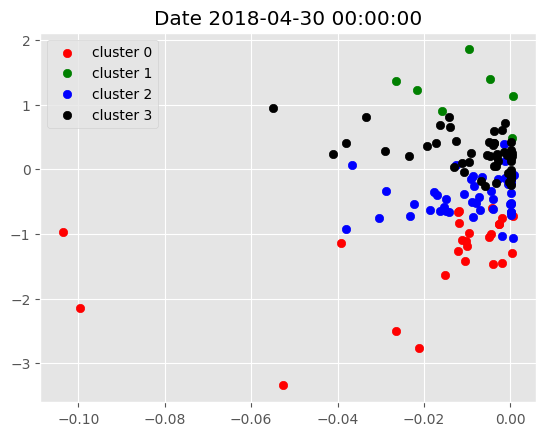

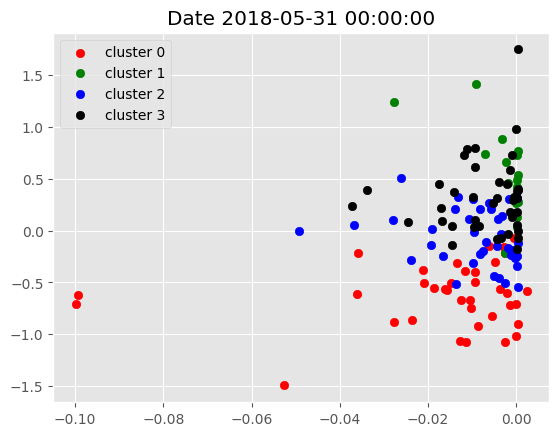

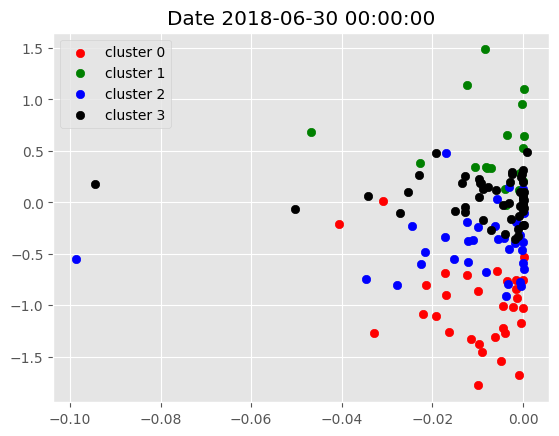

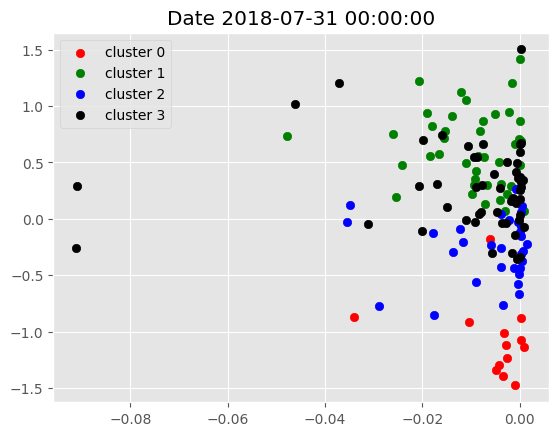

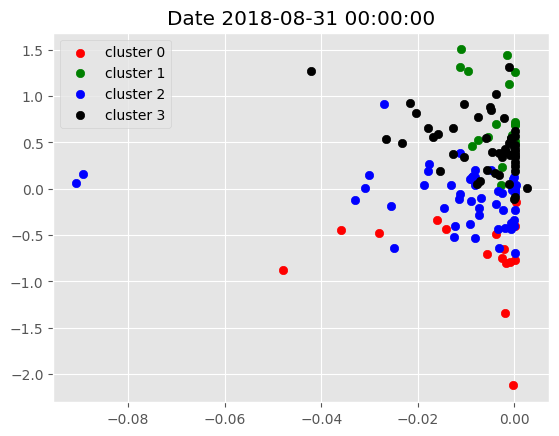

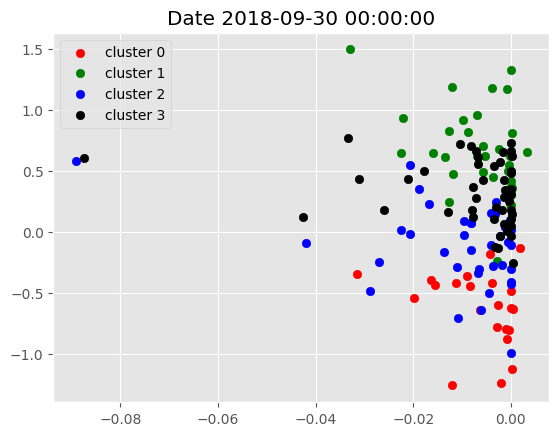

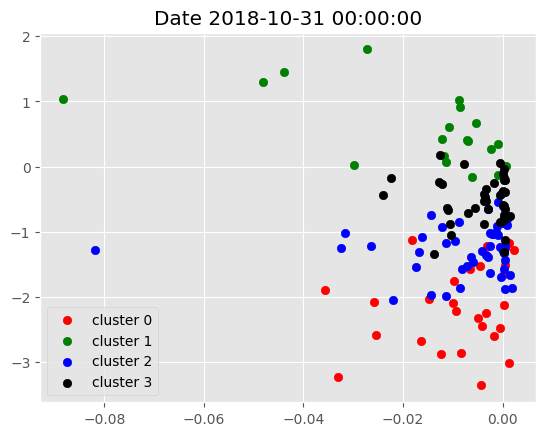

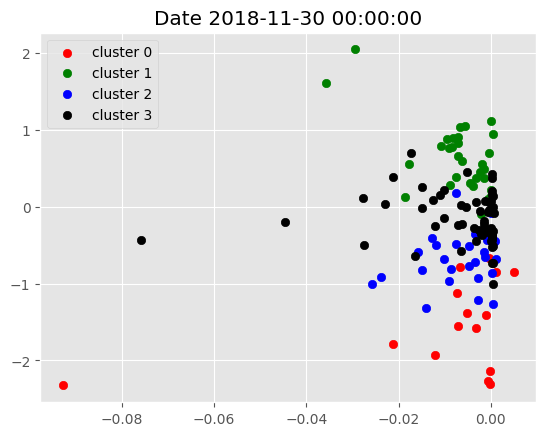

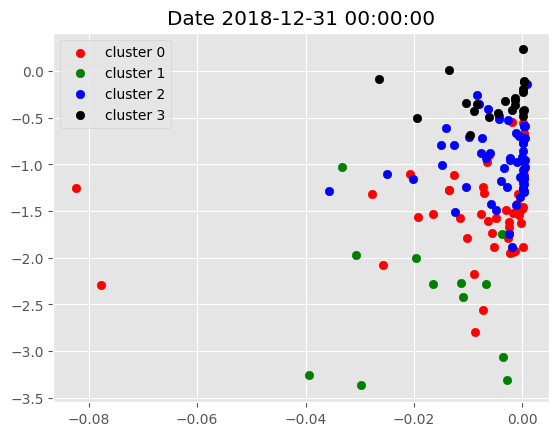

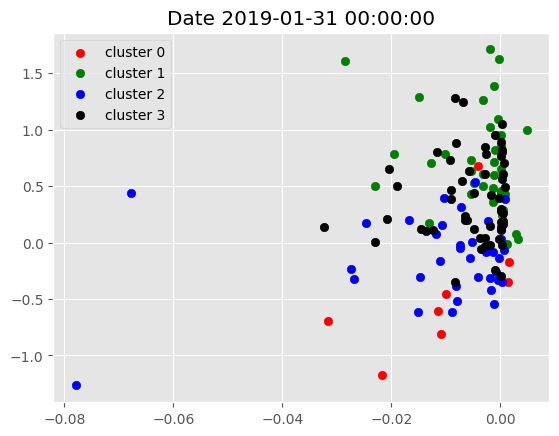

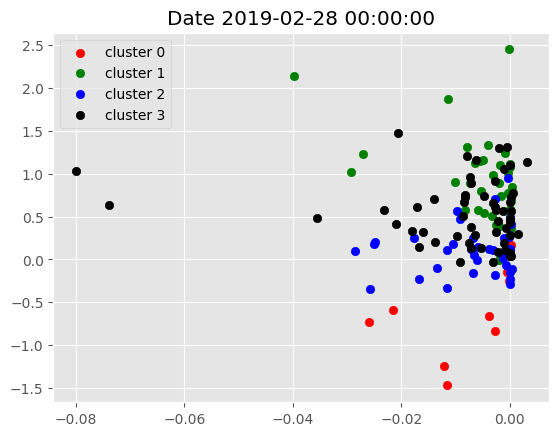

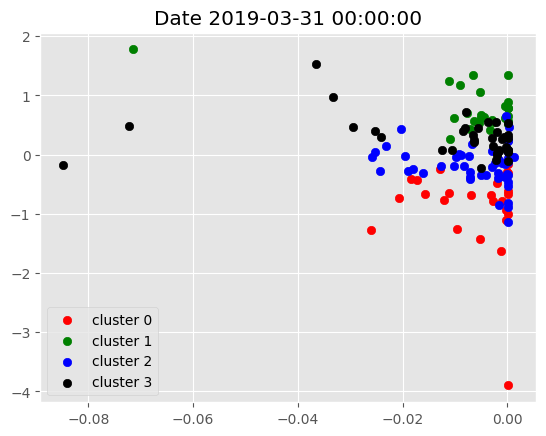

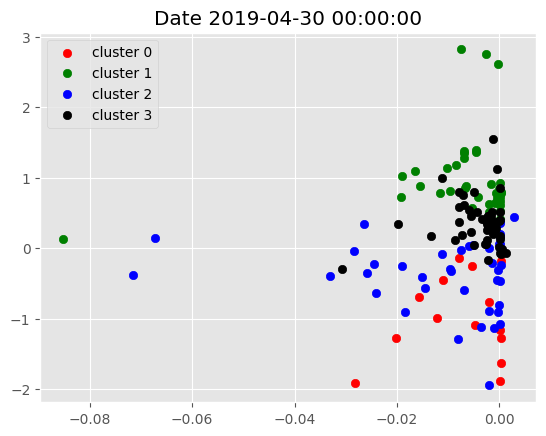

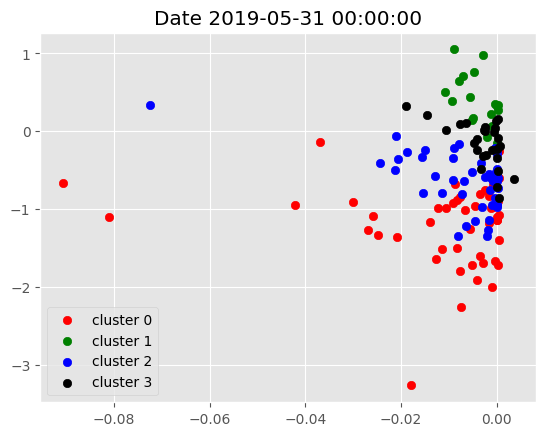

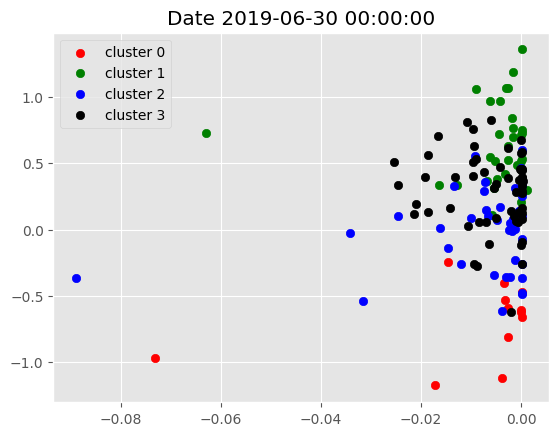

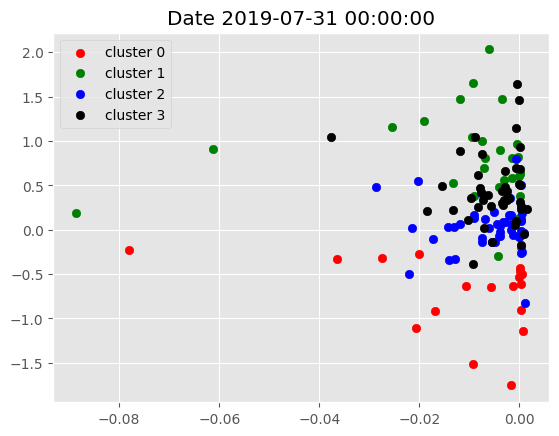

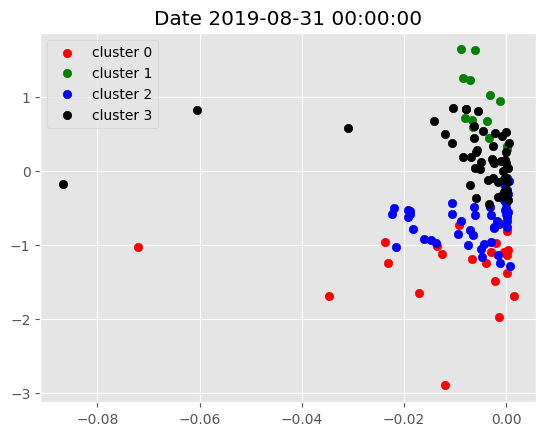

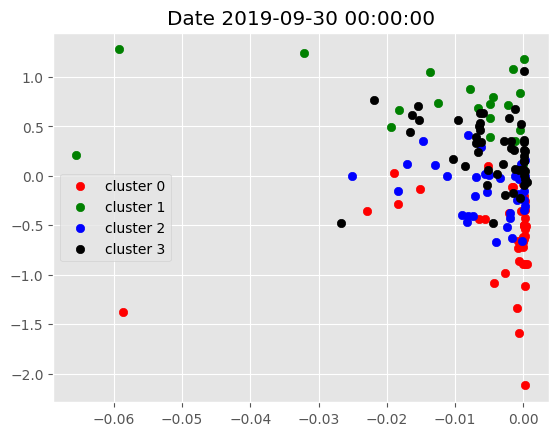

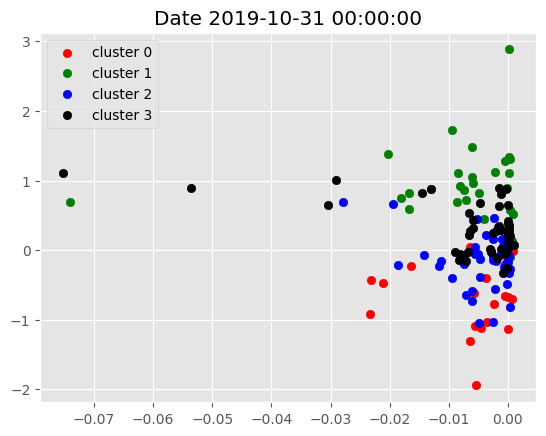

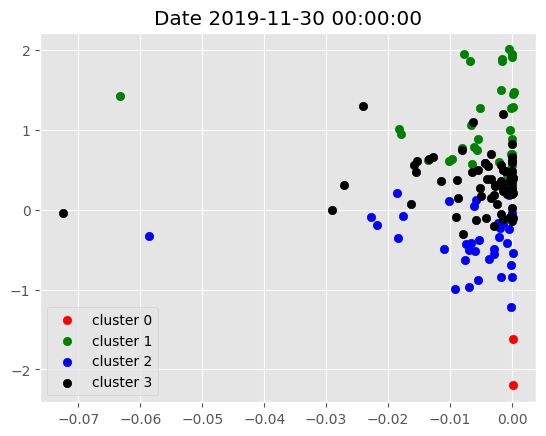

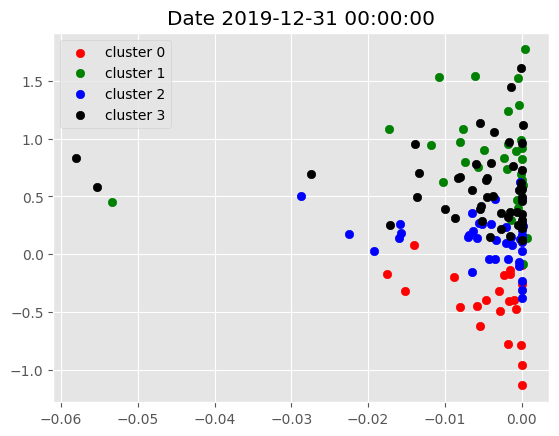

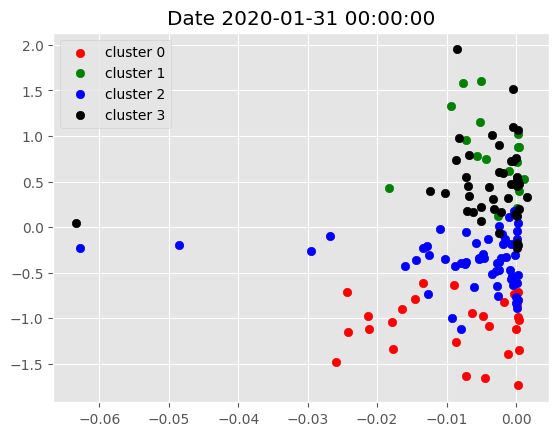

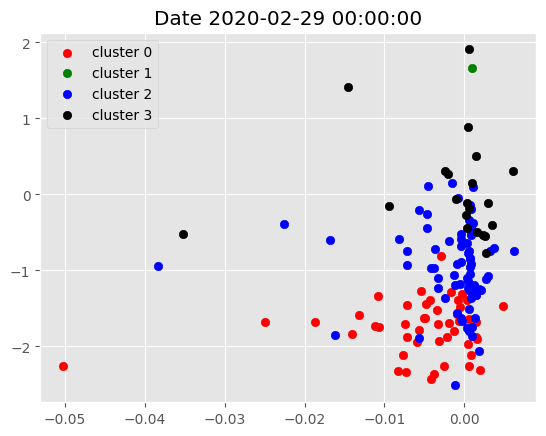

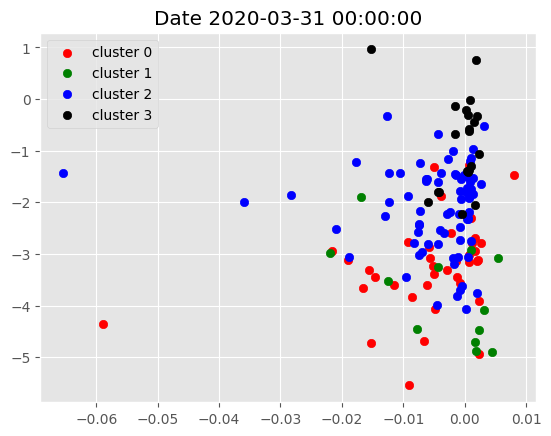

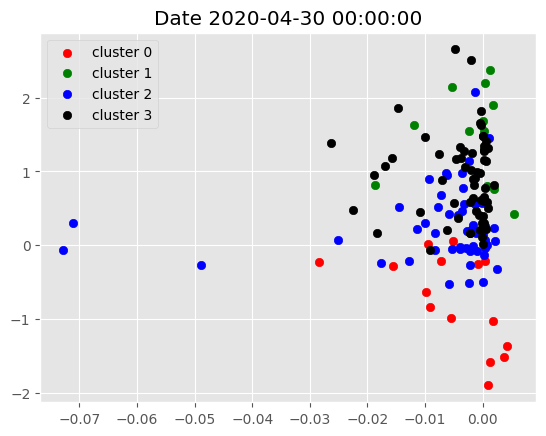

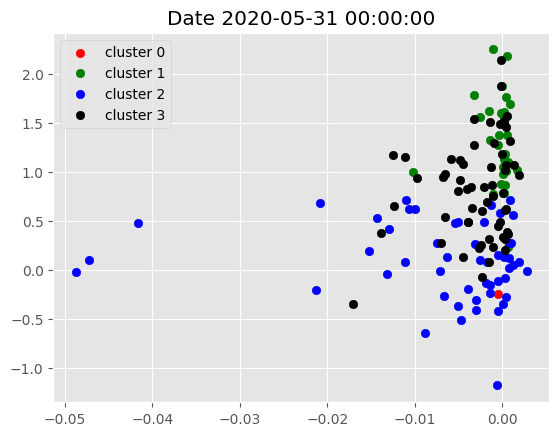

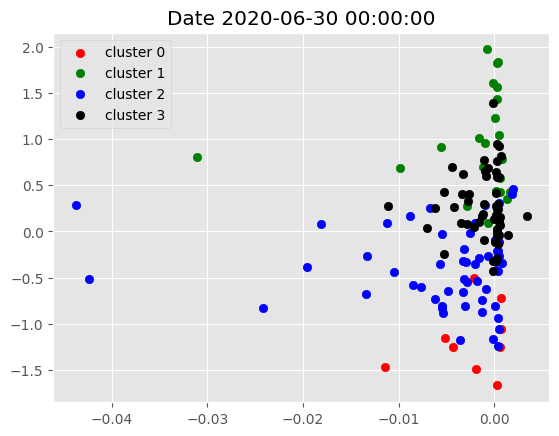

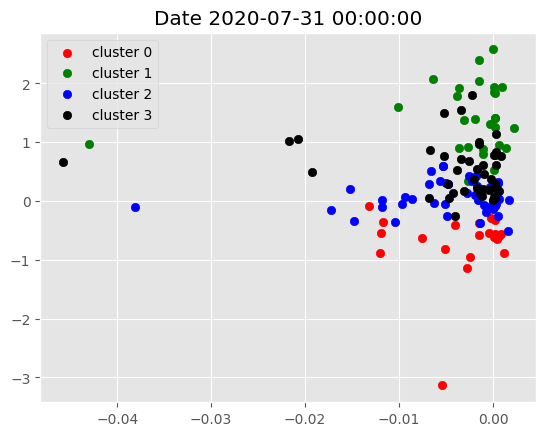

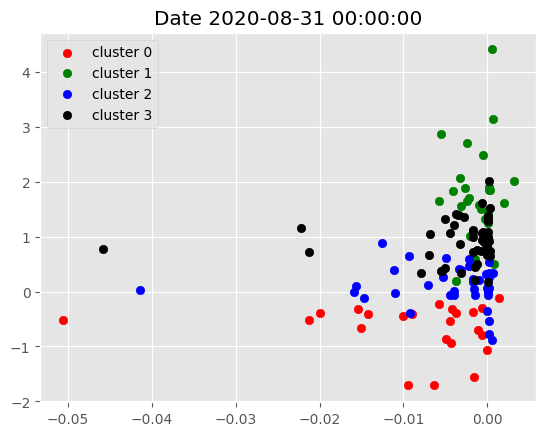

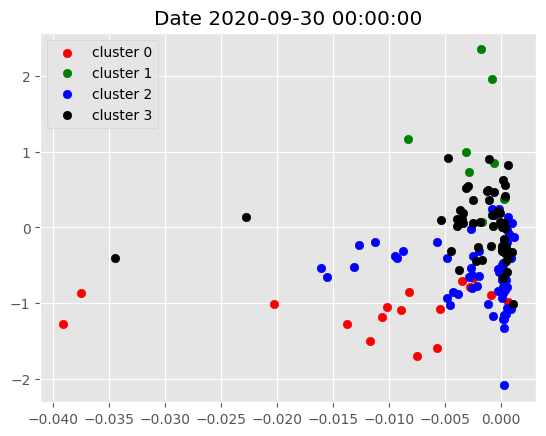

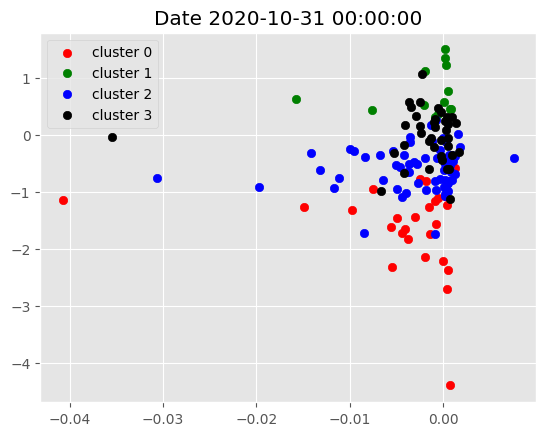

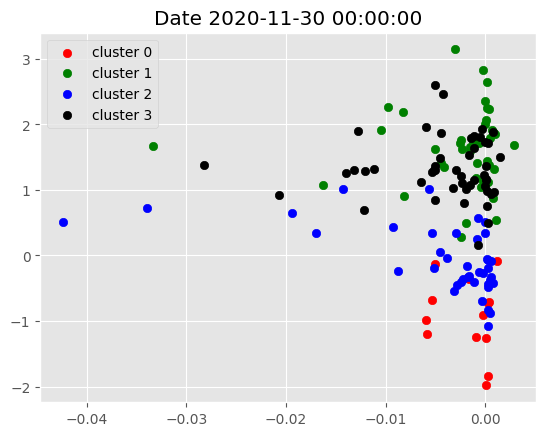

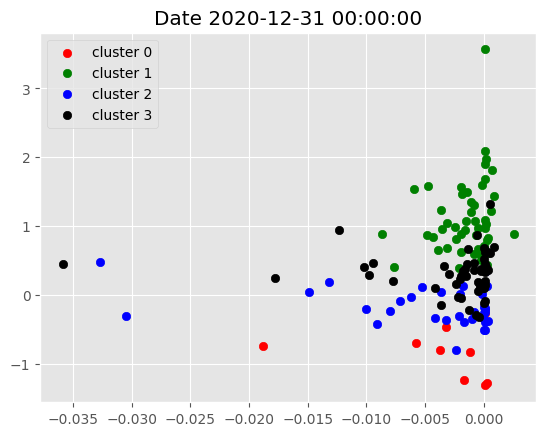

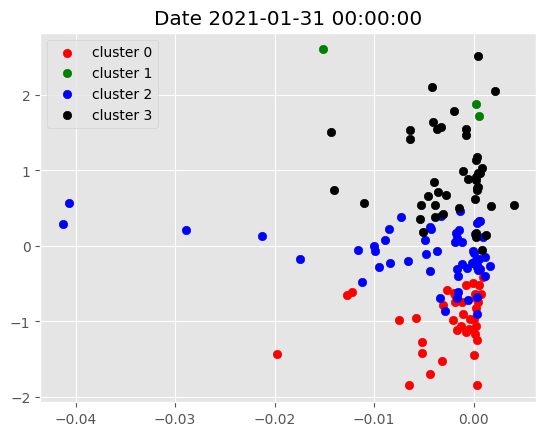

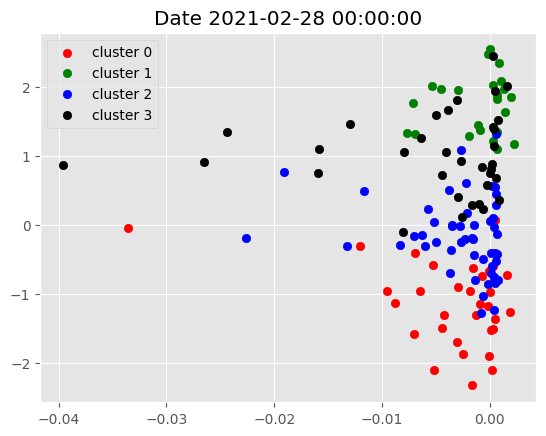

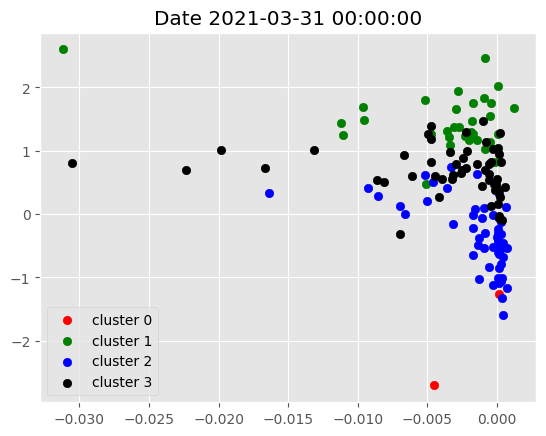

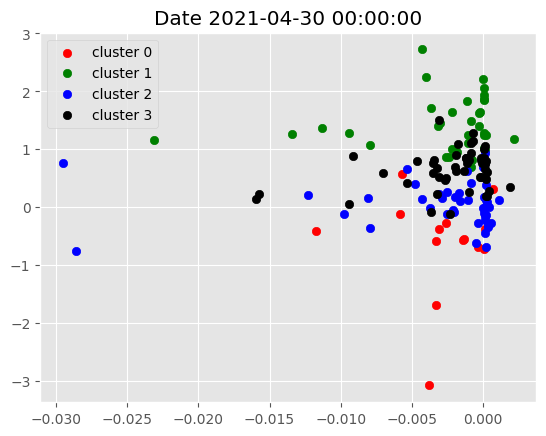

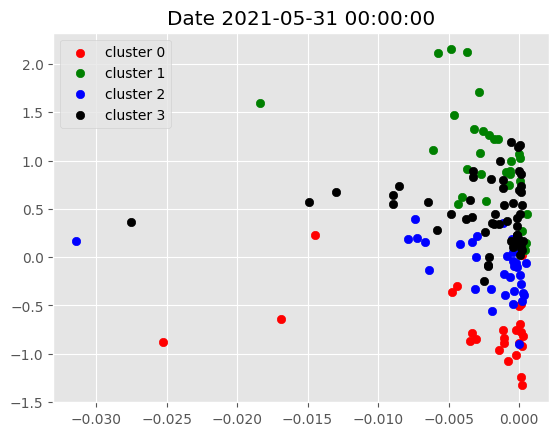

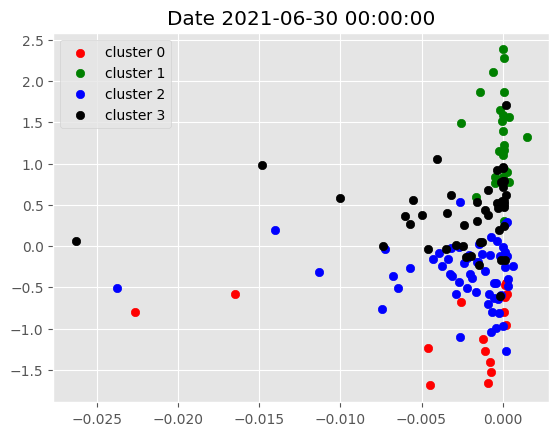

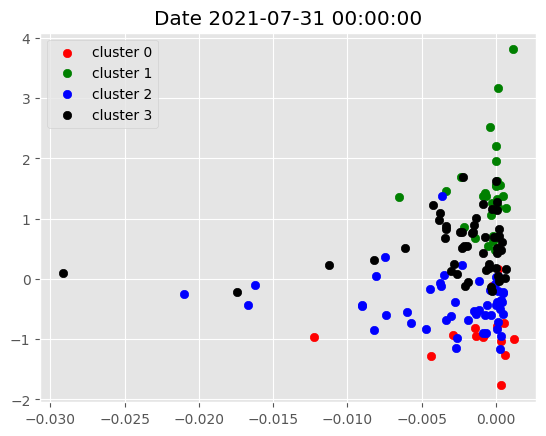

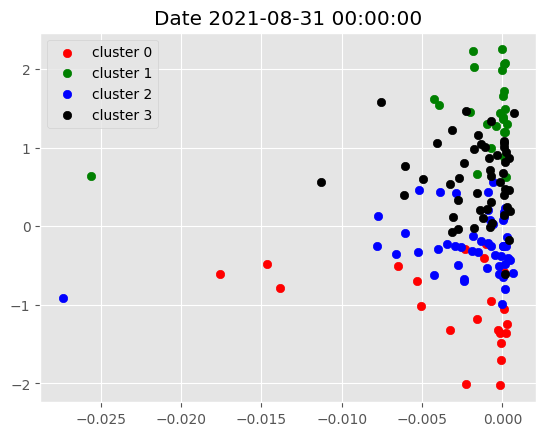

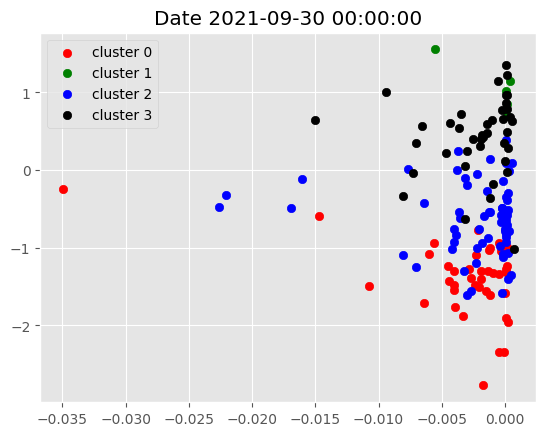

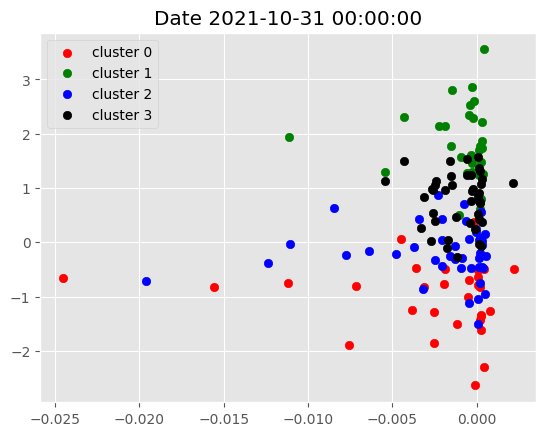

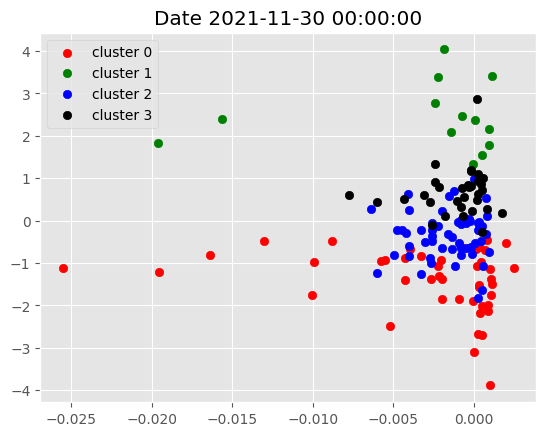

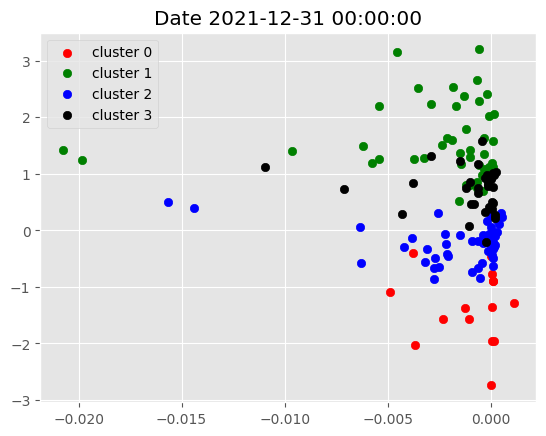

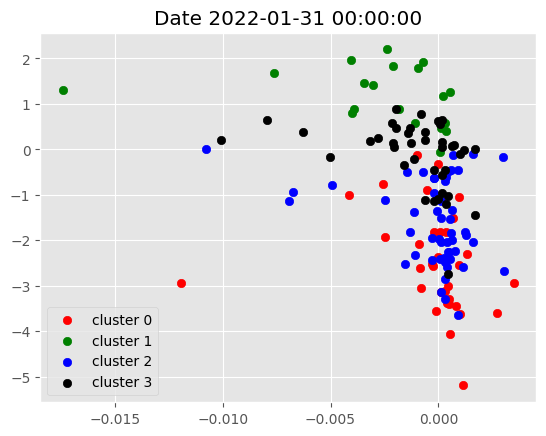

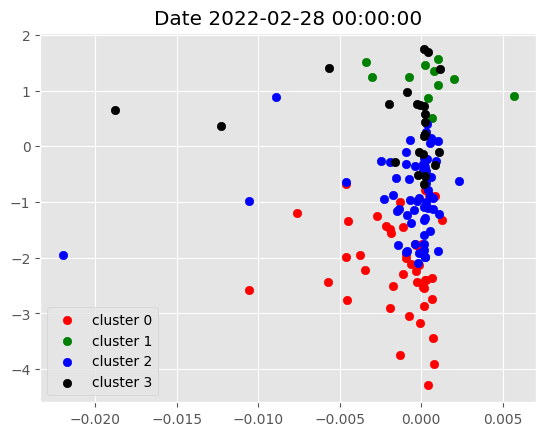

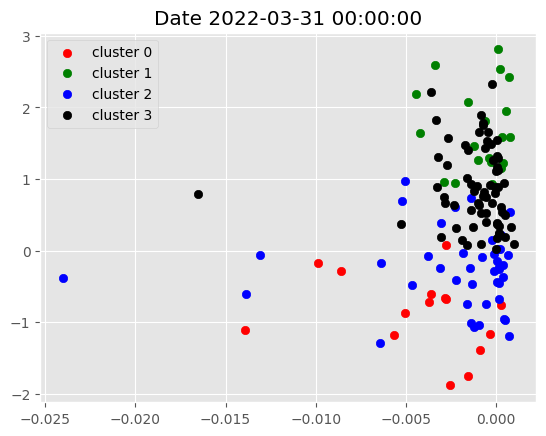

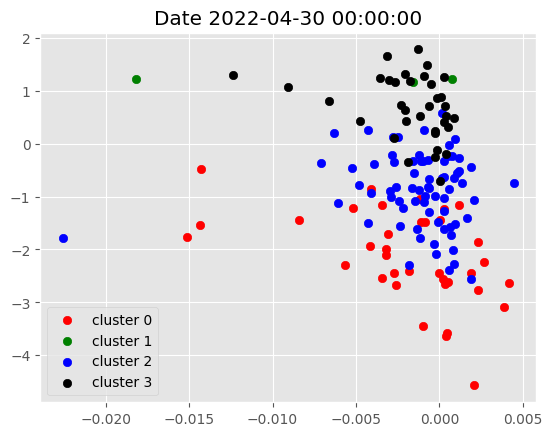

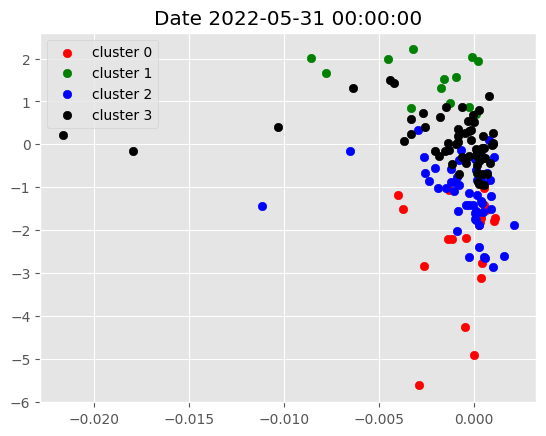

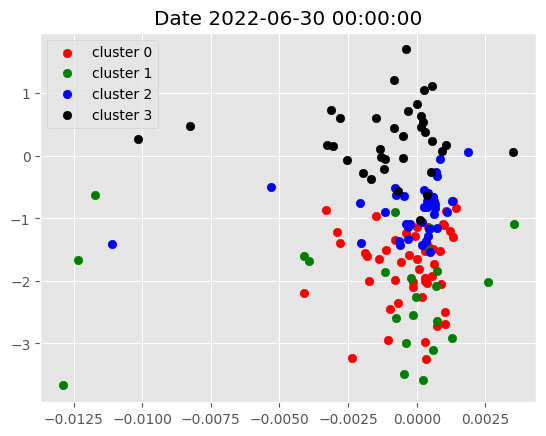

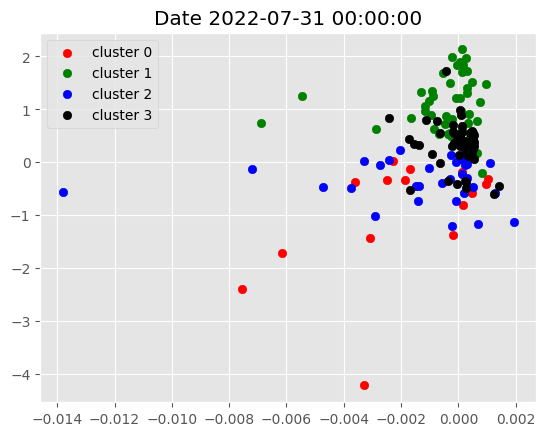

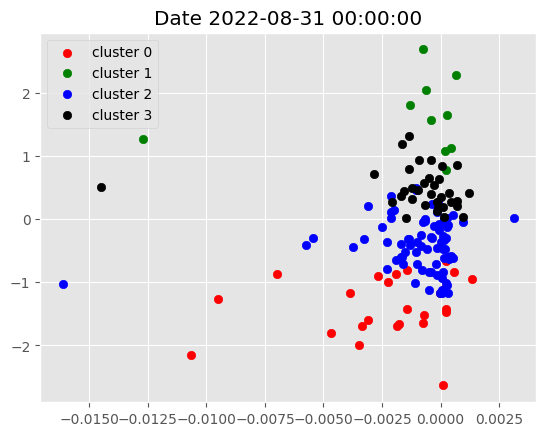

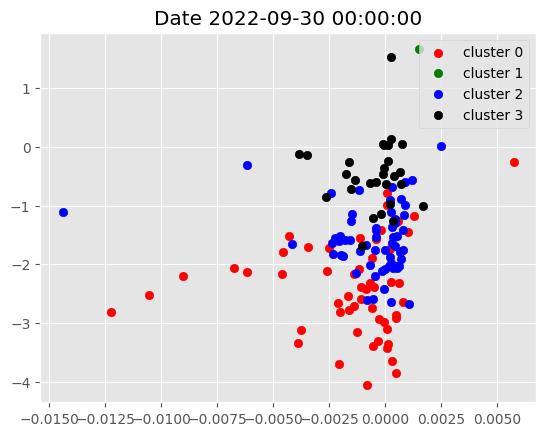

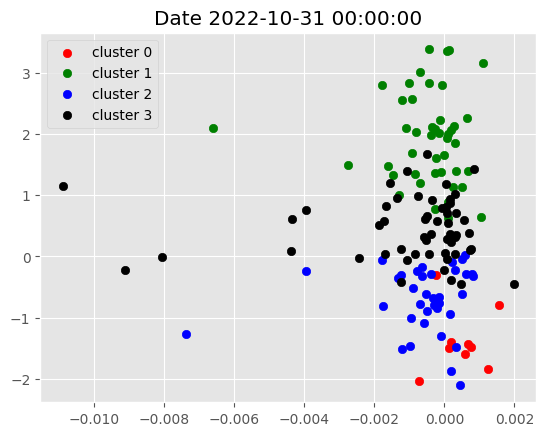

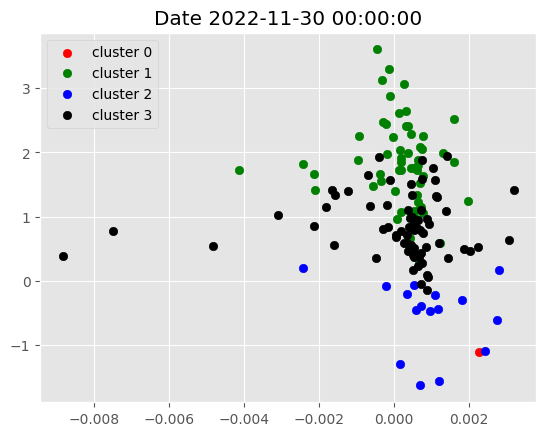

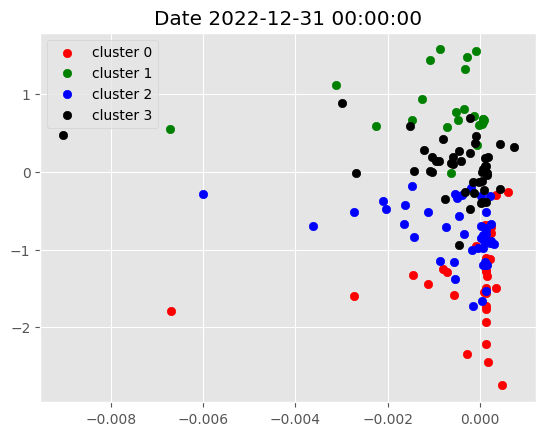

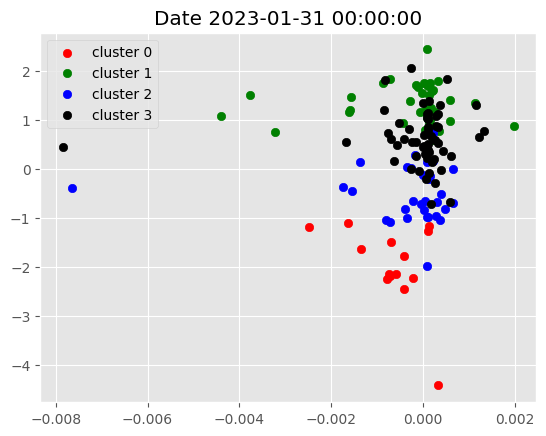

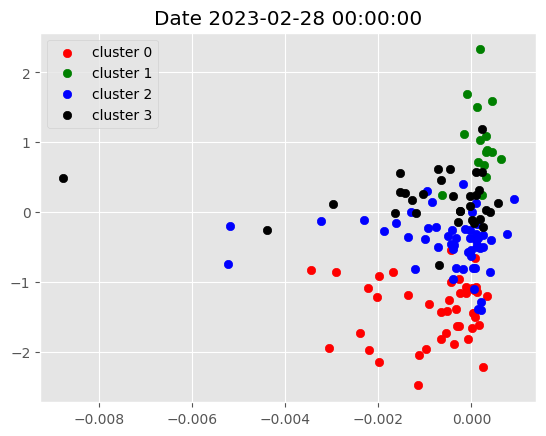

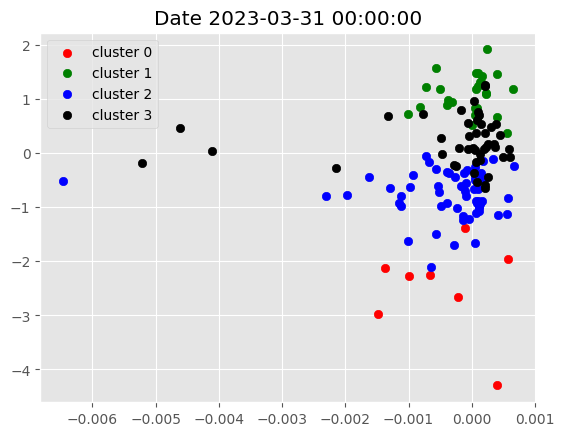

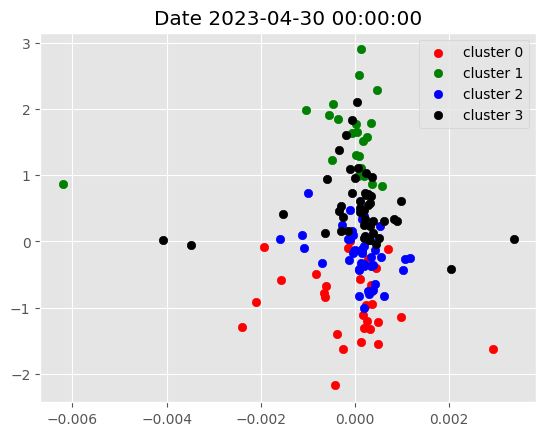

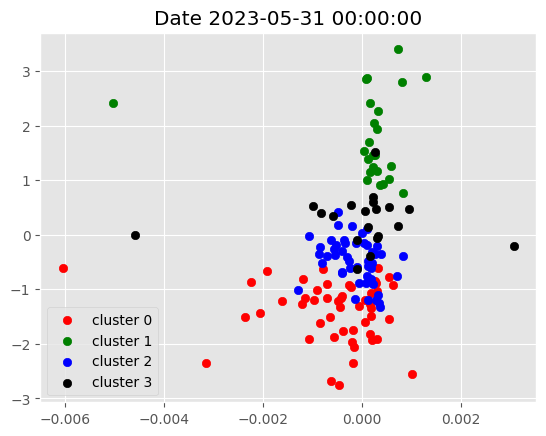

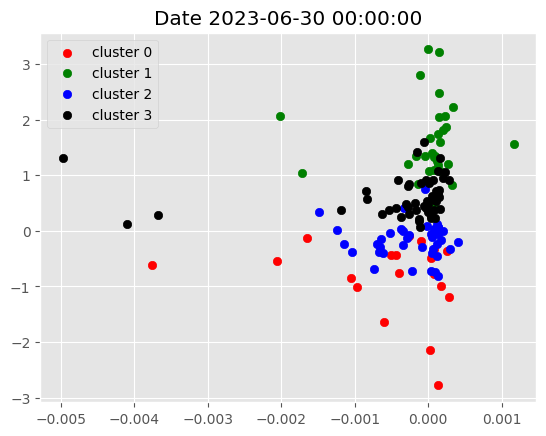

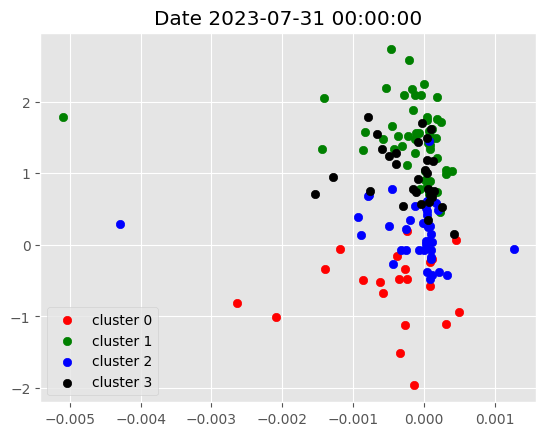

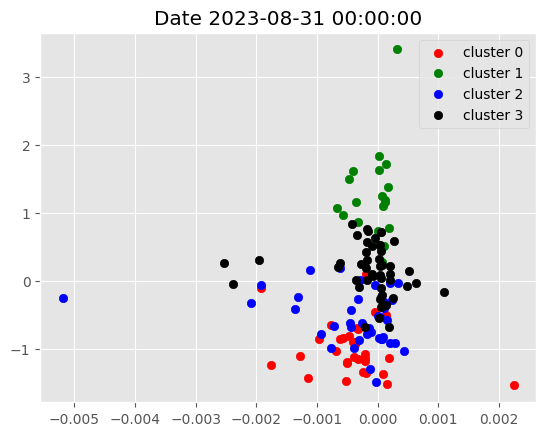

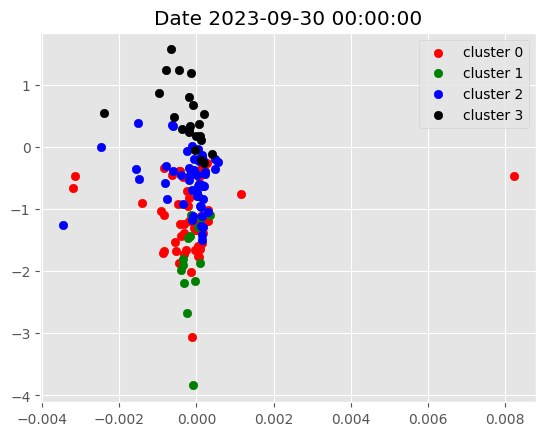

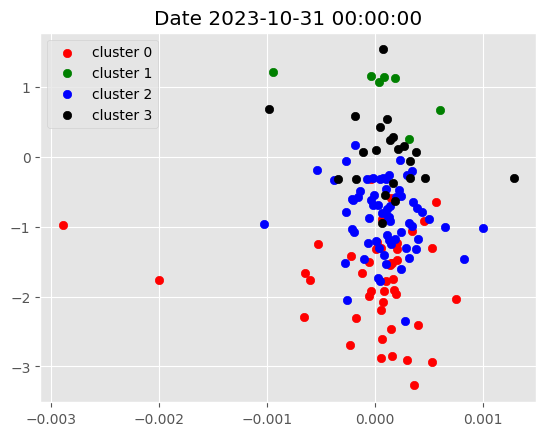

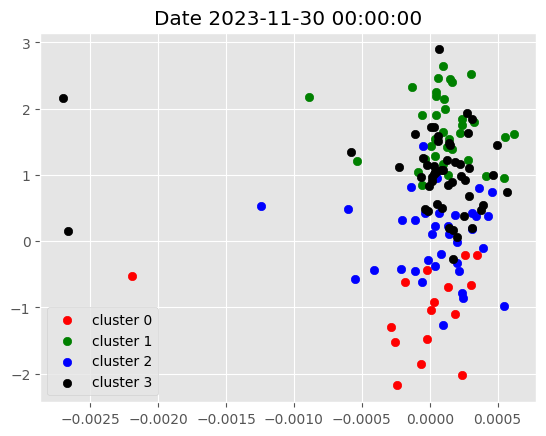

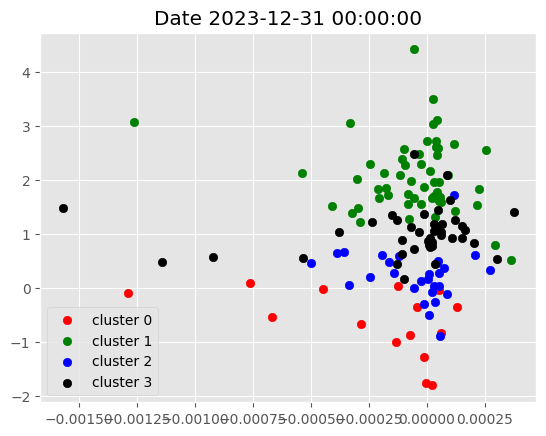

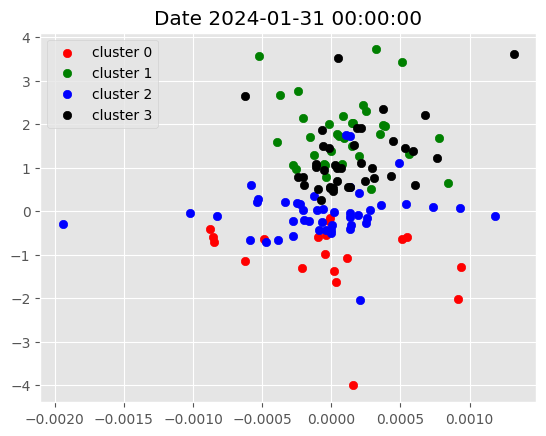

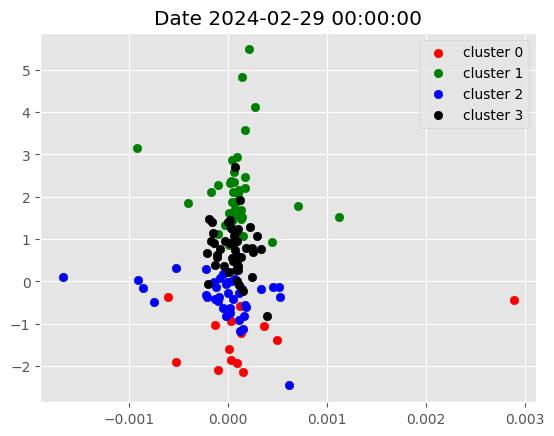

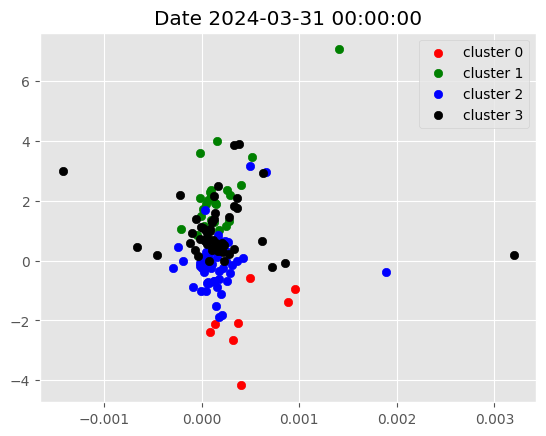

In [13]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

### Applying pre-defined centroids.

In [14]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First, only stocks corresponding to the cluster we choose based on our hypothesis will be filtered.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [15]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2018-04-01': ['ADBE',
  'BSX',
  'CMG',
  'COST',
  'CRM',
  'CSCO',
  'CSX',
  'CTSH',
  'DAL',
  'DG',
  'DHR',
  'EOG',
  'EXPE',
  'F',
  'GD',
  'HAL',
  'HUM',
  'LMT',
  'MA',
  'MDT',
  'MSFT',
  'MU',
  'NFLX',
  'NKE',
  'ORLY',
  'REGN',
  'SBUX',
  'UAL',
  'UNP',
  'V',
  'VLO',
  'WDC'],
 '2018-05-01': ['ADBE',
  'AIG',
  'AMD',
  'AMZN',
  'AXP',
  'BKNG',
  'BSX',
  'COST',
  'CRM',
  'CSCO',
  'CSX',
  'CTSH',
  'CVS',
  'CVX',
  'DG',
  'DHR',
  'ELV',
  'EXPE',
  'F',
  'FDX',
  'HD',
  'HUM',
  'INTC',
  'ISRG',
  'KR',
  'LLY',
  'MA',
  'MCD',
  'MCK',
  'MET',
  'META',
  'MRK',
  'MSFT',
  'NEE',
  'NFLX',
  'NKE',
  'ORLY',
  'PANW',
  'PFE',
  'SCHW',
  'SLB',
  'STZ',
  'TGT',
  'TJX',
  'UNH',
  'UPS',
  'V',
  'VZ',
  'WYNN',
  'XOM'],
 '2018-06-01': ['AAPL',
  'ABT',
  'ACN',
  'AMGN',
  'AVGO',
  'BA',
  'BSX',
  'COP',
  'COST',
  'CRM',
  'EA',
  'F',
  'GOOG',
  'GOOGL',
  'HD',
  'HUM',
  'INTC',
  'ISRG',
  'MA',
  'MDT',
  'MPC',
  'MRK',
  'MSFT'

### Define portfolio optimization function

* A function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio will be defined.

* To optimize the weights of a given portfolio, prices from the last year need to be supplied to the function.

* Apply single stock weight bounds constraint for diversification (minimum half of equal weight and maximum 10% of portfolio).

In [16]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


* Download Fresh Daily Prices Data only for short listed stocks.

In [17]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%***********************]  158 of 158 completed


Price                       Adj Close                                      \
Ticker                           AAPL        ABBV         ABT         ACN   
Date                                                                        
2017-03-31 00:00:00+00:00   33.442238   46.682087   38.674023  105.915359   
2017-04-03 00:00:00+00:00   33.451569   46.588947   38.726273  103.936310   
2017-04-04 00:00:00+00:00   33.700645   46.646255   38.473736  104.289696   
2017-04-05 00:00:00+00:00   33.526047   46.538795   38.142803  103.936310   
2017-04-06 00:00:00+00:00   33.442238   46.624771   38.029606  103.203003   
...                               ...         ...         ...         ...   
2024-03-22 00:00:00+00:00  171.847733  173.801636  108.930336  333.373291   
2024-03-25 00:00:00+00:00  170.421326  173.879547  108.378639  329.738312   
2024-03-26 00:00:00+00:00  169.284195  174.522354  109.846542  332.276886   
2024-03-27 00:00:00+00:00  172.875137  175.652161  111.797180  336.771240   
2024-03-28 00:00:00+00:00  171.049744  177.356552  111.974518  342.371887   

Price                                                                      \
Ticker                           ADBE         ADI         ADP        ADSK   
Date                                                                        
2017-03-31 00:00:00+00:00  130.130005   70.960884   87.389305   86.470001   
2017-04-03 00:00:00+00:00  129.589996   70.346092   86.433380   85.389999   
2017-04-04 00:00:00+00:00  130.039993   70.346092   86.587006   84.949997   
2017-04-05 00:00:00+00:00  129.889999   69.306992   86.996689   83.540001   
2017-04-06 00:00:00+00:00  130.149994   69.549454   86.843040   84.070000   
...                               ...         ...         ...         ...   
2024-03-22 00:00:00+00:00  499.519989  191.988235  244.952835  262.859985   
2024-03-25 00:00:00+00:00  507.230011  189.130890  241.579422  261.570007   
2024-03-26 00:00:00+00:00  507.600006  187.474030  242.440094  261.670013   
2024-03-27 00:00:00+00:00  504.399994  191.809662  245.665115  260.970001   
2024-03-28 00:00:00+00:00  504.600006  196.234573  247.059982  260.420013   

Price                                             ...   Volume           \
Ticker                           AIG        ALGN  ...        V      VLO   
Date                                              ...                     
2017-03-31 00:00:00+00:00  51.294243  114.709999  ...  6429800  3622100   
2017-04-03 00:00:00+00:00  50.768394  116.360001  ...  9125800  3319400   
2017-04-04 00:00:00+00:00  51.088833  115.610001  ...  4859900  3101500   
2017-04-05 00:00:00+00:00  50.628723  114.800003  ...  7251600  3236700   
2017-04-06 00:00:00+00:00  50.809475  115.190002  ...  8473900  3378100   
...                              ...         ...  ...      ...      ...   
2024-03-22 00:00:00+00:00  75.552109  319.420013  ...  8743000  3497100   
2024-03-25 00:00:00+00:00  75.759827  319.279999  ...  8519200  2767900   
2024-03-26 00:00:00+00:00  76.551163  319.940002  ...  8752400  3025300   
2024-03-27 00:00:00+00:00  77.490860  327.899994  ...  5190700  3098600   
2024-03-28 00:00:00+00:00  77.322708  327.920013  ...  5844400  3325900   

Price                                                                       \
Ticker                        VRTX        VZ       WBA       WDC       WFC   
Date                                                                         
2017-03-31 00:00:00+00:00  2849200  19299100   3133200   4155100  11864600   
2017-04-03 00:00:00+00:00  2040800  14307400   3283600   4051500  14550700   
2017-04-04 00:00:00+00:00  2913800   8952800   3273400   2902400  11937400   
2017-04-05 00:00:00+00:00  4032600  14327600  12117400   4093400  17411700   
2017-04-06 00:00:00+00:00  1959300  18456100   4696700   3160000  10387500   
...                            ...       ...       ...       ...       ...   
2024-03-22 00:00:00+00:00   821700  17815600   8219000   5438700  13736200   
2024-03-25 

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [46]:
# Calculate the returns dataframe
returns_dataframe = np.log(new_df['Adj Close']).diff()

# Initialize the portfolio DataFrame
portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    try:
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df.loc[optimization_start_date:optimization_end_date, 'Adj Close'][cols]

        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                       lower_bound=round(1 / (len(optimization_df.columns) * 2), 3))
            weights = pd.DataFrame(weights, index=optimization_df.columns, columns=['weight'])
            success = True
        except Exception as e:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights. Error: {e}')

        if not success:
            weights = pd.DataFrame([1 / len(optimization_df.columns) for _ in range(len(optimization_df.columns))],
                                   index=optimization_df.columns, columns=['weight'])

        temp_df = returns_dataframe.loc[start_date:end_date, cols]

        temp_df = temp_df.stack().to_frame('return').reset_index()
        temp_df.columns = ['Date', 'Ticker', 'Return']

        merged_df = temp_df.merge(weights, left_on='Ticker', right_index=True)
        merged_df['weighted_return'] = merged_df['Return'] * merged_df['weight']

        strategy_returns = merged_df.groupby('Date')['weighted_return'].sum().to_frame('Strategy Return')
        portfolio_df = pd.concat([portfolio_df, strategy_returns], axis=0)

    except Exception as e:
        print(f'Error processing start_date {start_date}: {e}')

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df


,Strategy Return
Date,
2018-04-02 00:00:00+00:00,0


## 8. Visualize Portfolio returns and compare to SP500 returns.

In [44]:
spy = yf.download(tickers='SPY', start='2015-01-01', end=dt.date.today())
spy.index = spy.index.tz_localize(None)

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close': 'SPY Buy&Hold'}, axis=1)

portfolio_df.index = portfolio_df.index.tz_localize(None)

portfolio_df = portfolio_df.merge(spy_ret, left_index=True, right_index=True)

portfolio_df

[*********************100%***********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
Date,,
2018-04-02,0,-0.021821


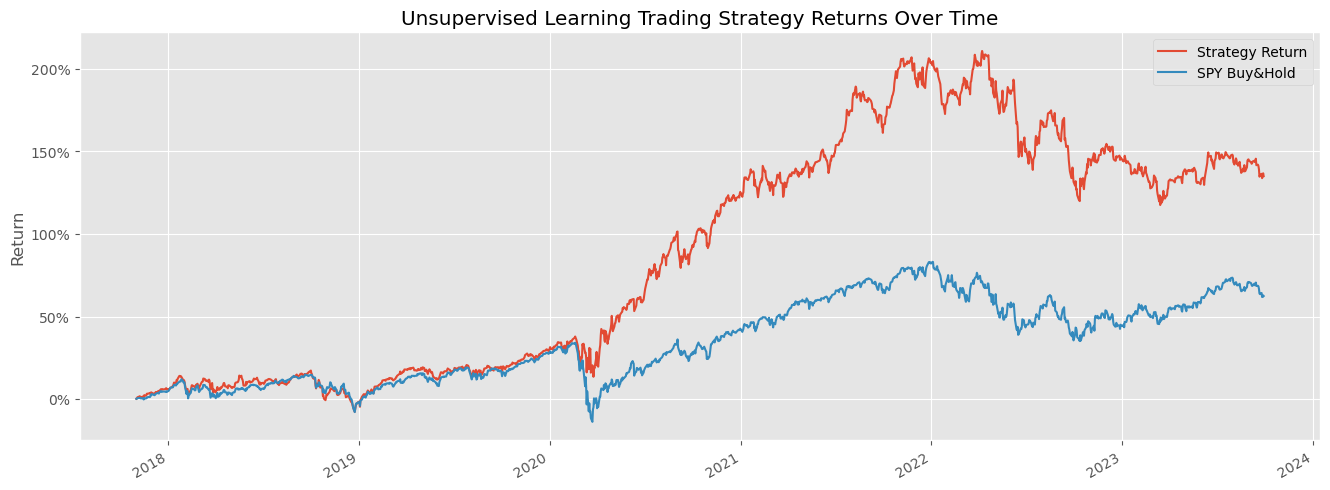

In [375]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()
